In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [50]:
df = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)
df.head()

Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1

In [51]:
df.shape

(1000, 2)

In [52]:
df.isna().sum()

Review    0
Liked     0
dtype: int64

In [53]:
#sentiment count
df['Liked'].value_counts()

1    500
0    500
Name: Liked, dtype: int64

In [54]:
# checking out the negative comments from the dataset
df_negative = df[df['Liked'] == 0]
df_negative.head()

Review  Liked
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
5     Now I am getting angry and I want my damn pho.      0
6              Honeslty it didn't taste THAT fresh.)      0
7  The potatoes were like rubber and you could te...      0

In [55]:
# checking out the positive comments from the dataset
df_positive = df[df['Liked'] == 1]
df_positive.head()

Review  Liked
0                           Wow... Loved this place.      1
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1
8                          The fries were great too.      1
9                                     A great touch.      1

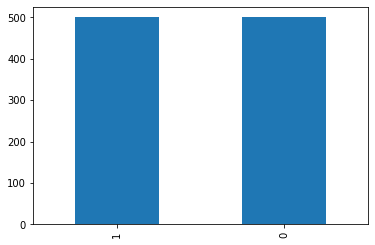

In [56]:
df['Liked'].value_counts().plot.bar(figsize = (6, 4))


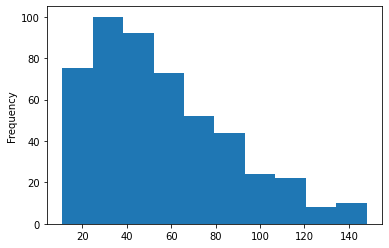

In [57]:
# checking the distribution of positive reviews
length_positive = df_positive['Review'].str.len().plot.hist(figsize = (6, 4))

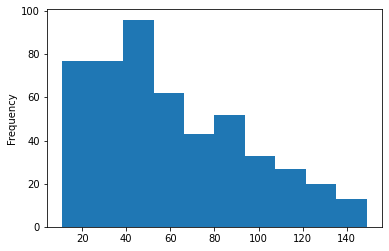

In [58]:
# checking the distribution of negative reviews
length_negative = df_negative['Review'].str.len().plot.hist(figsize = (6, 4))

In [59]:
# adding a column to represent the length of the review

df['len'] = df['Review'].str.len()
df.head()

Review  Liked  len
0                           Wow... Loved this place.      1   24
1                                 Crust is not good.      0   18
2          Not tasty and the texture was just nasty.      0   41
3  Stopped by during the late May bank holiday of...      1   87
4  The selection on the menu was great and so wer...      1   59

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

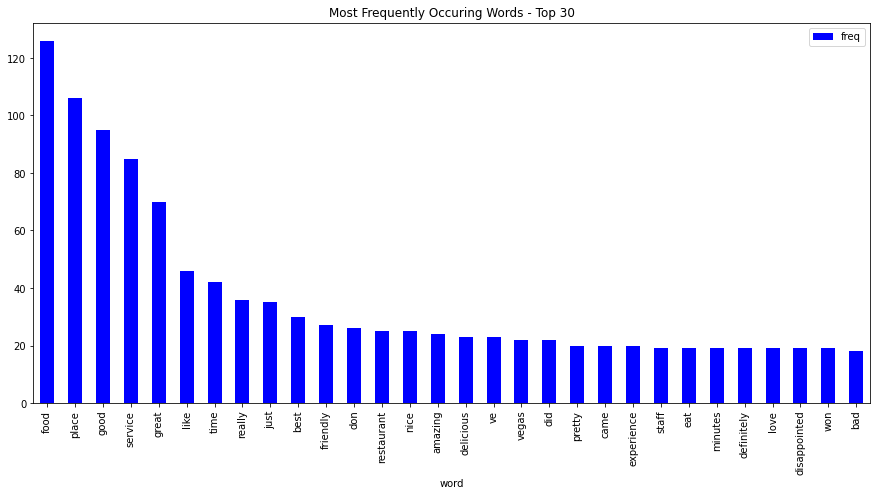

In [60]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.Review)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

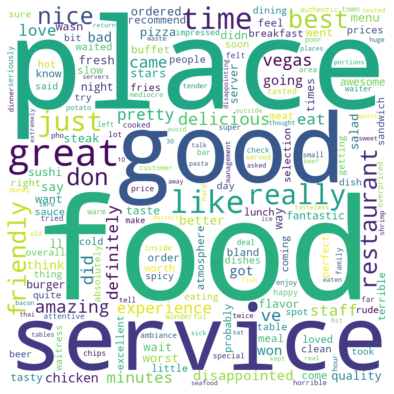

In [61]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

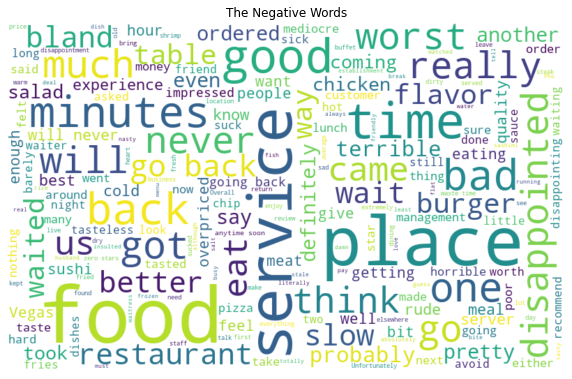

In [62]:
negative_words =' '.join([text for text in df_negative.Review])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

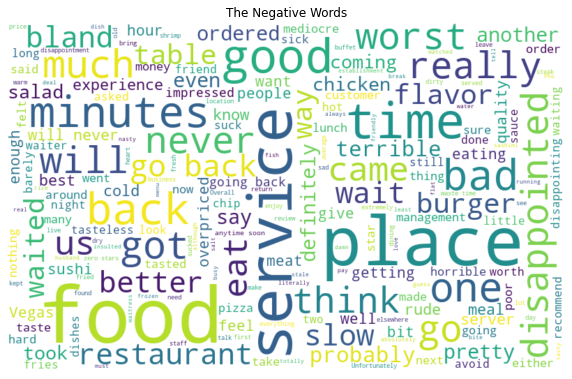

In [63]:
positive_words =' '.join([text for text in df_positive.Review])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

In [64]:
# removing unwanted patterns from the data

import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
df_corpus = []

for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  df_corpus.append(review)
df_corpus[:5]

['wow love place',
 'crust good',
 'tasti textur nasti',
 'stop late may bank holiday rick steve recommend love',
 'select menu great price']

In [66]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(df_corpus).toarray()
y = df.iloc[:, 1]

print(x.shape)
print(y.shape)

(1000, 1565)
(1000,)


In [67]:
# splitting the training data into train and valid sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(700, 1565)
(300, 1565)
(700,)
(300,)


In [68]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_mean=False)

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 1.0
Validation Accuracy : 0.7433333333333333
F1 score : 0.7072243346007605
[[130  22]
 [ 55  93]]


In [70]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9971428571428571
Validation Accuracy : 0.7433333333333333
f1 score : 0.7389830508474577
[[114  38]
 [ 39 109]]


In [71]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 1.0
Validation Accuracy : 0.7266666666666667
f1 score : 0.7071428571428573
[[119  33]
 [ 49  99]]


In [72]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9514285714285714
Validation Accuracy : 0.69
f1 score : 0.7173252279635258
[[ 89  63]
 [ 30 118]]


In [73]:
best_model = RandomForestClassifier()
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_valid)

print("Training Accuracy :", best_model.score(x_train, y_train))
print("Validation Accuracy :", best_model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 1.0
Validation Accuracy : 0.73
F1 score : 0.6848249027237353
[[131  21]
 [ 60  88]]


In [74]:
# save the model to disk
import joblib
joblib.dump(cv, open("vector.pickel", "wb"))
joblib.dump(sc, open("StandardScaler.pickel", "wb"))
joblib.dump(best_model, "model.pickle")

['model.pickle']

In [78]:
# load the CountVectorizer and Model from disk


cv = joblib.load(open("vector.pickel", "rb"))
test_data_features = cv.transform(["not bad"])
sc = joblib.load(open("StandardScaler.pickel", "rb"))
text = sc.transform(test_data_features)
loaded_model = joblib.load("model.pickle")
result = loaded_model.predict(text)
print(result)

[0]
